    Bond Length (Å)  Energy (Hartree)
0            0.2500         -0.305001
1            0.3125         -0.648096
2            0.3750         -0.848599
3            0.4375         -0.969726
4            0.5000         -1.042996
5            0.5625         -1.085710
6            0.6250         -1.108150
7            0.6875         -1.116848
8            0.7500         -1.116151
9            0.8125         -1.109016
10           0.8750         -1.097454
11           0.9375         -1.082838
12           1.0000         -1.066109
13           1.0625         -1.047931
14           1.1250         -1.028797
15           1.1875         -1.009089
16           1.2500         -0.989114
17           1.3125         -0.969121
18           1.3750         -0.949314
19           1.4375         -0.929855
20           1.5000         -0.910874
21           1.5625         -0.892468
22           1.6250         -0.874712
23           1.6875         -0.857660
24           1.7500         -0.841349
25          

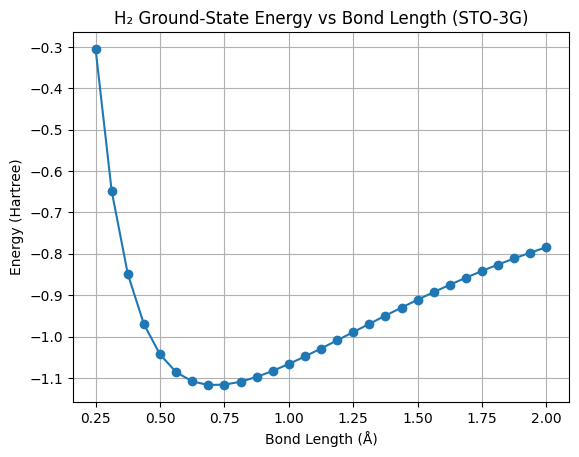

In [ ]:
import numpy as np
import pandas as pd

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit

# Bond lengths in Angstrom
bond_lengths = np.linspace(0.25, 2.0, 29)

energies = []

for r in bond_lengths:
    # Define H2 geometry
    geometry = f"H 0 0 0; H 0 0 {r}"

    # PySCF driver
    driver = PySCFDriver(
        atom=geometry,
        basis="sto3g",
        spin=0,
        charge=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # Run electronic structure calculation
    problem = driver.run()

    # Ground-state energy (electronic + nuclear repulsion)
    energy = problem.reference_energy

    energies.append(energy)

# Create table
df = pd.DataFrame({
    "Bond Length (Å)": bond_lengths,
    "Energy (Hartree)": energies
})

print(df)
import matplotlib.pyplot as plt

plt.plot(bond_lengths, energies, marker='o')
plt.xlabel("Bond Length (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("Classical: H₂ Ground-State Energy vs Bond Length (STO-3G)")
plt.grid(True)
plt.show()


/tmp/ipykernel_33134/1446953903.py:52: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


    Bond Length (Å)  VQE (UCCSD) Energy (Ha)
0            0.2500                -0.312270
1            0.3125                -0.656269
2            0.3750                -0.857883
3            0.4375                -0.980336
4            0.5000                -1.055160
5            0.5625                -1.099669
6            0.6250                -1.124161
7            0.6875                -1.135188
8            0.7500                -1.137117
9            0.8125                -1.132929
10           0.8750                -1.124672
11           0.9375                -1.113751
12           1.0000                -1.101150
13           1.0625                -1.087577
14           1.1250                -1.073563
15           1.1875                -1.059522
16           1.2500                -1.045783
17           1.3125                -1.032606
18           1.3750                -1.020189
19           1.4375                -1.008673
20           1.5000                -0.998149
21        

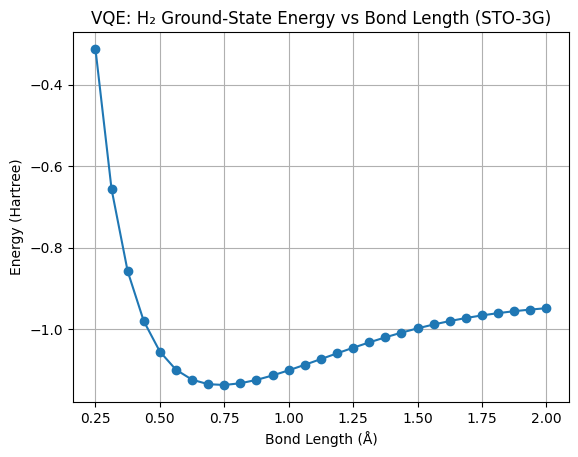

In [11]:
import numpy as np
import pandas as pd

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.units import DistanceUnit

bond_lengths = np.linspace(0.25, 2.00, 29)
vqe_energies = []

for R in bond_lengths:
    # --- Driver ---
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {R}",
        basis="sto3g",
        unit=DistanceUnit.ANGSTROM,
        charge=0,
        spin=0
    )

    problem = driver.run()

    # --- Mapper ---
    mapper = JordanWignerMapper()

    # --- Ansatz ---
    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    hf_state = HartreeFock(
        num_spatial_orbitals,
        num_particles,
        mapper
    )

    ansatz = UCCSD(
    num_spatial_orbitals=num_spatial_orbitals,
    num_particles=num_particles,
    initial_state=hf_state
    )
    ansatz.qubit_mapper = mapper


    # --- VQE ---
    optimizer = SLSQP(maxiter=1000)
    estimator = Estimator()

    vqe = VQE(
        estimator=estimator,
        ansatz=ansatz,
        optimizer=optimizer,
        initial_point=np.zeros(ansatz.num_parameters)
    )

    solver = GroundStateEigensolver(mapper, vqe)
    result = solver.solve(problem)

    vqe_energies.append(result.total_energies[0].real)

df = pd.DataFrame({
    "Bond Length (Å)": bond_lengths,
    "VQE (UCCSD) Energy (Ha)": vqe_energies
})

print(df)

import matplotlib.pyplot as plt

plt.plot(bond_lengths, vqe_energies, marker='o')
plt.xlabel("Bond Length (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("VQE: H₂ Ground-State Energy vs Bond Length (STO-3G)")
plt.grid(True)
plt.show()
